In [2]:
import pandas as pd
import numpy as np
from utils import charas
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
OOS_start = 19870101
OOS_end = 20161231

def calculate_R2(model, type, portfolio = True):
    if portfolio:
        portfolio_ret = pd.read_pickle('data/portfolio_ret.pkl')
    else:
        raise Exception('Unrealized Function')
    oos_ret = portfolio_ret.loc[(portfolio_ret['DATE'] >= OOS_start) & (portfolio_ret['DATE'] <= OOS_end)]
    
    output_path = f'results/{type}/{model}_{type}.csv'
    model_output = pd.read_csv(output_path)
    
    residual_square = (oos_ret.set_index('DATE') - model_output.set_index('DATE'))**2
    residual_square = (1 - (residual_square == np.inf) * 1.0) * residual_square # drop Inf outliers
    
    total_square = oos_ret.set_index('DATE')**2
    total_square = (1 - (total_square == np.inf) * 1.0) * total_square # drop Inf outliers
    
    return 1 - np.sum(residual_square.values)/np.sum(total_square.values)

In [3]:
calculate_R2('PCA_6', 'inference')

0.8437256192223954

In [4]:
calculate_R2('FF_1', 'inference')

0.10434211289898665

In [5]:
def alpha_plot(model, type, portfolio = True):
    if not portfolio:
        raise Exception('Unrealized Function')
    
    portfolio_ret = pd.read_pickle('data/portfolio_ret.pkl')
    oos_result = portfolio_ret.loc[(portfolio_ret['DATE'] >= OOS_start) & (portfolio_ret['DATE'] <= OOS_end)].set_index('DATE')
    
    output_path = f'results/{type}/{model}_{type}.csv'
    inference_result = pd.read_csv(output_path)
    inference_result = inference_result.set_index('DATE')
    
    
    pricing_error_analysis = []
    for col in charas:
        raw_return = oos_result[col].mean()
        error = oos_result[col] - inference_result[col]
        alpha = error.mean()
        t_stat = abs(error.mean()/error.std()) * np.sqrt(oos_result.shape[0])
        pricing_error_analysis.append([raw_return, alpha, t_stat])

    pricing_error_analysis = pd.DataFrame(pricing_error_analysis, columns = ['raw ret', 'alpha', 't_stat'], index=charas)
    
    lower_point = min(np.min(pricing_error_analysis['raw ret']), np.min(pricing_error_analysis['alpha'])) * 1.15
    upper_point = max(np.max(pricing_error_analysis['raw ret']), np.max(pricing_error_analysis['alpha'])) * 1.15

    significant_mask = pricing_error_analysis['t_stat'] > 3

    plt.scatter(pricing_error_analysis.loc[significant_mask]['raw ret'], pricing_error_analysis.loc[significant_mask]['alpha'], marker='^', color='r', alpha=0.6, label=f'#Alphas(t>3.0)={np.sum(significant_mask*1.0)}')
    plt.scatter(pricing_error_analysis.loc[~significant_mask]['raw ret'], pricing_error_analysis.loc[~significant_mask]['alpha'], marker='o', color='b', alpha=0.6, label=f'#Alphas(t<3.0)={94-np.sum(significant_mask*1.0)}')
    plt.plot(np.linspace(lower_point, upper_point, 10), np.linspace(lower_point, upper_point, 10), color='black')

    plt.ylabel('Alpha')
    plt.xlabel('Raw Return')
    plt.legend()

    plt.title(model)
    plt.show()

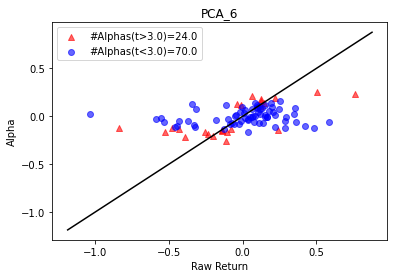

In [5]:
alpha_plot('PCA_6', 'inference')

In [7]:
alpha_plot('FF_1', 'inference')